In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


/home/marta/env/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df = pd.read_csv('../raw_data.csv')
df.head()

,startCarNumber,totalCarNumber,overhead,duration
0,448,450,2.391984,256
1,446,450,1.356133,41
2,446,450,1.859867,138
3,444,450,1.184140,188
4,447,450,1.495768,297


In [3]:
df.describe()

,startCarNumber,totalCarNumber,overhead,duration
count,198901.000000,198901.000000,198901.000000,1.989010e+05
mean,450.843611,463.724215,2.594940,8.310424e+02
std,153.410743,161.576640,3.923980,1.608582e+04
min,46.000000,50.000000,0.713012,2.000000e+00
25%,348.000000,350.000000,1.358850,1.760000e+02
50%,496.000000,500.000000,1.734835,3.010000e+02
75%,546.000000,550.000000,2.252161,4.660000e+02
max,703.000000,720.000000,30.000000,1.025447e+06


In [4]:
df_before = df.iloc[:108154, :].reset_index()
df_after = df.iloc[108154: , :].reset_index()

In [5]:
df_before.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,108154.000000,108154.000000,108154.000000,108154.000000,108154.000000
mean,54076.500000,445.602613,450.279694,1.901245,438.581291
std,31221.514844,153.376295,155.308700,1.117322,5499.725207
min,0.000000,46.000000,50.000000,0.717545,2.000000
25%,27038.250000,348.000000,350.000000,1.351517,174.000000
50%,54076.500000,497.000000,500.000000,1.704915,296.000000
75%,81114.750000,546.000000,550.000000,2.147151,446.000000
max,108153.000000,619.000000,620.000000,30.000000,330880.000000


In [6]:
df_after.describe()

,index,startCarNumber,totalCarNumber,overhead,duration
count,90747.000000,90747.000000,90747.000000,90747.000000,9.074700e+04
mean,153527.000000,457.089931,479.747650,3.421699,1.298785e+03
std,26196.546776,153.218656,167.338973,5.568128,2.303678e+04
min,108154.000000,47.000000,50.000000,0.713012,2.000000e+00
25%,130840.500000,348.000000,350.000000,1.367434,1.790000e+02
50%,153527.000000,495.000000,500.000000,1.778202,3.090000e+02
75%,176213.500000,551.000000,600.000000,2.423312,4.970000e+02
max,198900.000000,703.000000,720.000000,30.000000,1.025447e+06


In [7]:
df_before = df
df_before['c'] = df_before['totalCarNumber'].diff()
df_filtered = df_before[df_before['c'] != 0]

index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
print(len(index_list))
print('\n')
print(index_list)

l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

len(list_of_dfs)

47


[0, 7725, 17009, 26616, 33754, 38727, 39836, 43598, 44711, 47755, 57026, 66629, 76815, 86108, 91782, 95322, 104667, 114026, 124573, 135453, 142731, 146890, 148286, 157651, 160074, 162780, 165645, 167510, 168540, 168809, 170108, 170423, 171374, 174232, 176970, 178760, 181380, 183399, 184789, 187219, 189174, 191579, 192151, 193966, 195430, 195759, 198528]


47

In [8]:
one = list_of_dfs[1]

In [9]:
one['duration']

7725     251
7726     748
7727     144
7728     585
7729     488
        ... 
17004     66
17005    414
17006    330
17007    359
17008     56
Name: duration, Length: 9284, dtype: int64

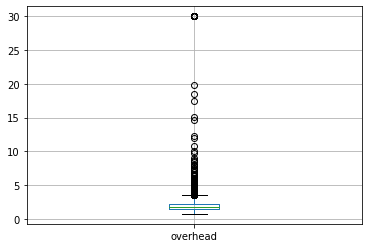

In [10]:
boxplot = one.boxplot(column=['overhead'])

In [11]:
one.describe()

,startCarNumber,totalCarNumber,overhead,duration,c
count,9284.000000,9284.0,9284.000000,9284.000000,9284.000000
mean,515.050732,520.0,1.992292,390.214240,0.007540
std,7.497144,0.0,1.483760,1297.651886,0.726491
min,444.000000,520.0,0.717545,3.000000,0.000000
25%,515.000000,520.0,1.372200,178.000000,0.000000
50%,516.000000,520.0,1.777295,308.000000,0.000000
75%,517.000000,520.0,2.246802,464.250000,0.000000
max,519.000000,520.0,30.000000,30661.000000,70.000000


In [12]:
duration_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    duration_df = pd.concat([duration_df,i['duration'].reset_index()['duration']], ignore_index=True, axis=1)
    counter += 1

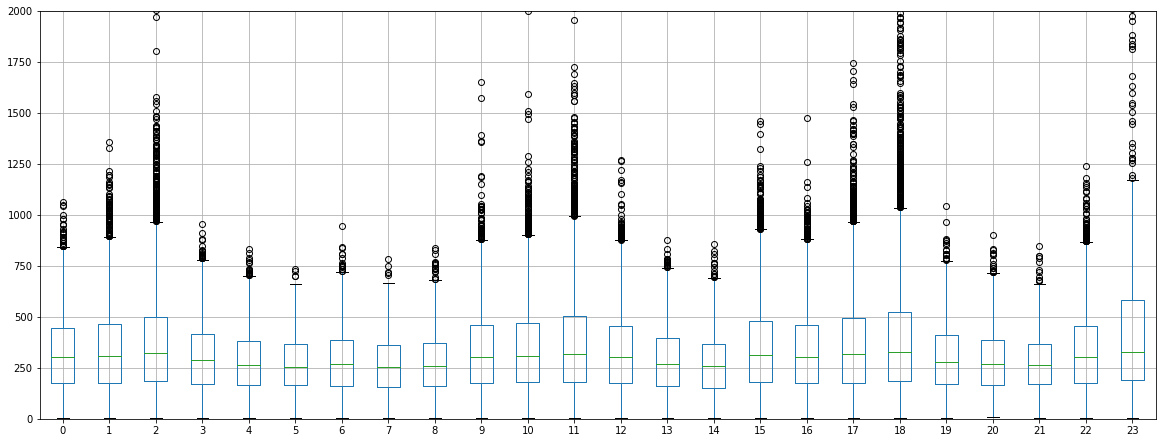

In [13]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

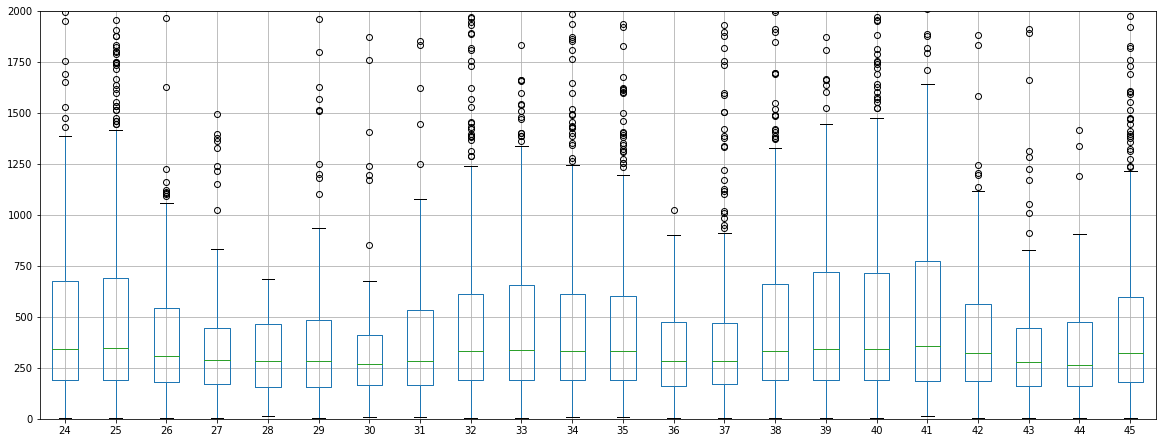

In [14]:
columns = list(range(24, 46))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = duration_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,2000])
plt.show()

In [15]:
overhead_df = pd.DataFrame()
counter = 0
for i in list_of_dfs:
    overhead_df = pd.concat([overhead_df,i['overhead'].reset_index()['overhead']], ignore_index=True, axis=1)
    counter += 1

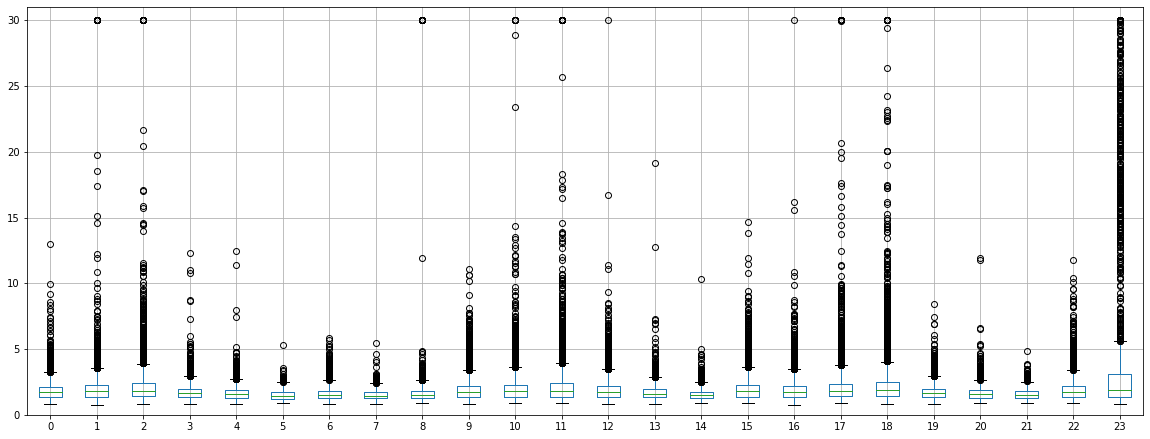

In [16]:
columns = list(range(0, 24))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

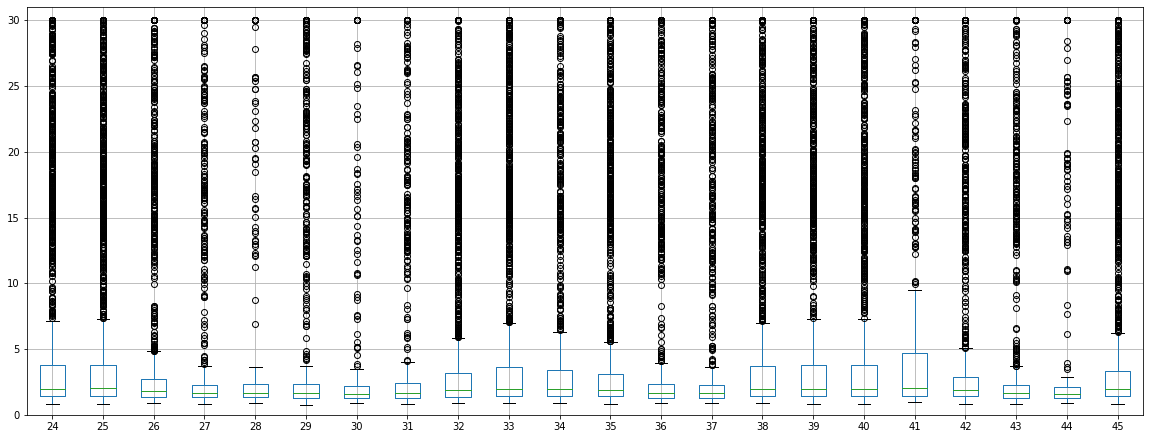

In [17]:
columns = list(range(24, 46))
fig, ax = plt.subplots(figsize=(20,7.5))
boxplot = overhead_df.boxplot(column=columns, ax=ax)
ax.set_ylim([0,31])
plt.show()

In [19]:
df_data = pd.read_csv('../data.csv')
df_data.head()

,index,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,0,450,944,1.742870,1.387800,2.108208,2.656046
1,1,450,1368,1.734339,1.374704,2.137847,2.675869
2,2,450,1344,1.768617,1.413413,2.179748,2.709206
3,3,450,1364,1.674457,1.352064,2.094166,2.585302
4,4,450,1377,1.719660,1.378597,2.162006,2.610691


In [20]:
df_data = df_data.iloc[::6, :].reset_index()
df_data = df_data.drop(columns=['index', 'level_0'])
df_data.head(10)

# ax = df_data.plot.bar( y='numberOfTrips', rot=90, figsize=(20,7.5))

,totalCarNumber,numberOfTrips,median_overhead,q1_overhead,q3_overhead,p9_overhead
0,450,944,1.742870,1.387800,2.108208,2.656046
1,520,1553,1.812621,1.389571,2.297695,2.912667
2,600,1540,1.856177,1.405185,2.431929,3.286327
3,350,1136,1.671423,1.368085,2.029742,2.468087
4,200,835,1.579370,1.300936,1.878537,2.213042
5,50,199,1.460782,1.222948,1.746853,1.968742
6,200,635,1.554009,1.295297,1.819757,2.142958
7,50,204,1.501653,1.266109,1.781647,2.109984
8,150,522,1.556650,1.299692,1.852657,2.301268
9,500,1515,1.763604,1.390871,2.247038,2.879923


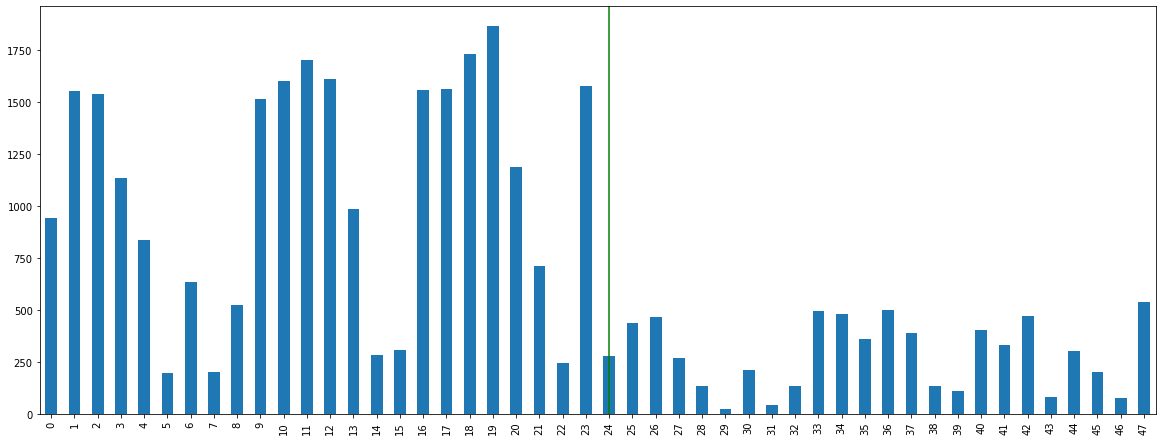

In [21]:
fig, ax = plt.subplots(figsize=(20,7.5))
ax = df_data.plot.bar(y='numberOfTrips', rot=90, ax=ax, legend=None)
ax.axvline(x=24, c='g')